In [1]:
! pip install gplugins[sax]

In [91]:
import logging
import sys
from functools import partial
from pprint import pprint

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange

import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

gf.config.set_plot_options(show_subports=False)

o2            o3
   \        /
    ========
   /        \
o1            o4

In [4]:
coupling = 0.5
kappa = coupling**0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("o1", "o4"): tau,
    ("o4", "o1"): tau,
    ("o1", "o3"): 1j * kappa,
    ("o3", "o1"): 1j * kappa,
    ("o2", "o4"): 1j * kappa,
    ("o4", "o2"): 1j * kappa,
    ("o2", "o3"): tau,
    ("o3", "o2"): tau,
}
print(coupler_dict)

{('o1', 'o4'): 0.7071067811865476, ('o4', 'o1'): 0.7071067811865476, ('o1', 'o3'): 0.7071067811865476j, ('o3', 'o1'): 0.7071067811865476j, ('o2', 'o4'): 0.7071067811865476j, ('o4', 'o2'): 0.7071067811865476j, ('o2', 'o3'): 0.7071067811865476, ('o3', 'o2'): 0.7071067811865476}


In [5]:
coupler_dict = sax.reciprocal(
    {
        ("o1", "o4"): tau,
        ("o1", "o3"): 1j * kappa,
        ("o2", "o4"): 1j * kappa,
        ("o2", "o3"): tau,
    }
)

coupler_dict

{
    ('o1', 'o4'): 0.7071067811865476,
    ('o1', 'o3'): 0.7071067811865476j,
    ('o2', 'o4'): 0.7071067811865476j,
    ('o2', 'o3'): 0.7071067811865476,
    ('o4', 'o1'): 0.7071067811865476,
    ('o3', 'o1'): 0.7071067811865476j,
    ('o4', 'o2'): 0.7071067811865476j,
    ('o3', 'o2'): 0.7071067811865476
}

In [6]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    return sax.reciprocal(
        {
            ("o1", "o4"): tau,
            ("o1", "o3"): 1j * kappa,
            ("o2", "o4"): 1j * kappa,
            ("o2", "o3"): tau,
        }
    )


coupler(coupling=0.3)

{
    ('o1', 'o4'): 0.8366600265340756,
    ('o1', 'o3'): 0.5477225575051661j,
    ('o2', 'o4'): 0.5477225575051661j,
    ('o2', 'o3'): 0.8366600265340756,
    ('o4', 'o1'): 0.8366600265340756,
    ('o3', 'o1'): 0.5477225575051661j,
    ('o4', 'o2'): 0.5477225575051661j,
    ('o3', 'o2'): 0.8366600265340756
}

In [7]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

2024-04-18 20:34:10.115 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\Waveguide_a6b10dff9e1ecbcd.npz.


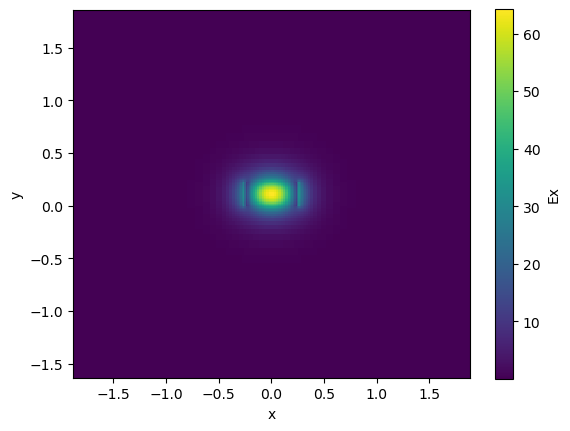

In [8]:
nm = 1e-3
strip = gt.modes.Waveguide(
    wavelength=1.55,
    core_width=500 * nm,
    core_thickness=220 * nm,
    slab_thickness=0.0,
    core_material="si",
    clad_material="sio2",
    group_index_step=10 * nm,
)
strip.plot_field(field_name="Ex", mode_index=0)  # TE

In [9]:
neff = strip.n_eff[0]
print(neff)

(2.511347336097549+4.427776281104384e-05j)


In [10]:
ng = strip.n_group[0]
print(ng)

4.17803969357238


In [11]:
straight_sc = partial(gs.models.straight, neff=neff, ng=ng)

(-1.0, 1.0)

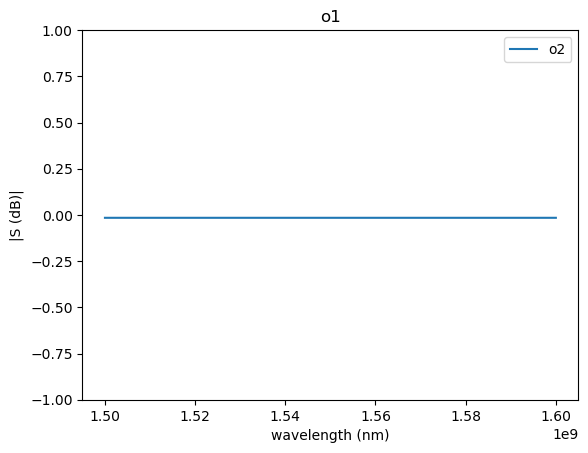

In [12]:
gs.plot_model(straight_sc)
plt.ylim(-1, 1)

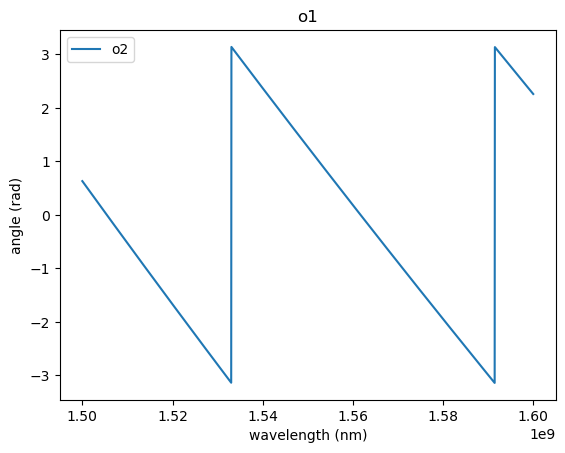

In [13]:
gs.plot_model(straight_sc, phase=True)

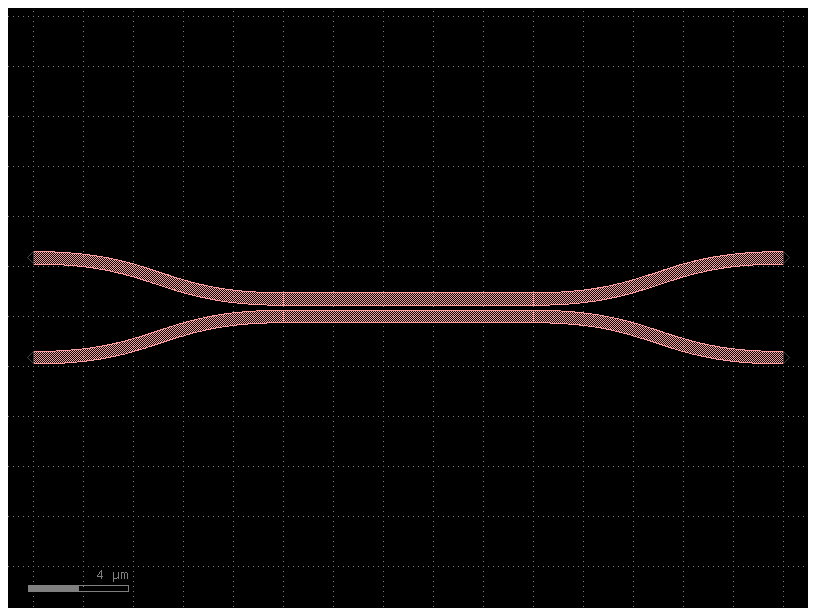

In [14]:
c = gf.components.coupler(length=10, gap=0.2)
c.plot()

2024-04-18 20:35:30.659 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_384f5c5749dcebed.npz.


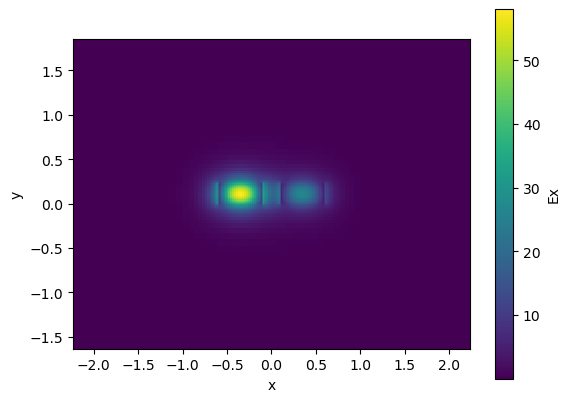

In [15]:
nm = 1e-3
cp = gt.modes.WaveguideCoupler(
    wavelength=1.55,
    core_width=(500 * nm, 500 * nm),
    gap=200 * nm,
    core_thickness=220 * nm,
    slab_thickness=0 * nm,
    core_material="si",
    clad_material="sio2",
)
cp.plot_field(field_name="Ex", mode_index=0)  # even mode

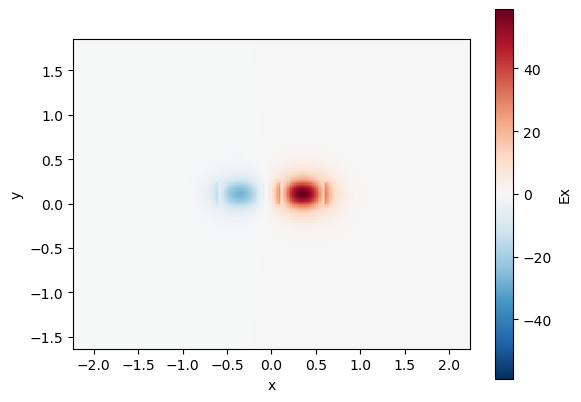

In [16]:
cp.plot_field(field_name="Ex", mode_index=1)  # odd mode

2024-04-18 20:35:55.248 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_2c192ae832460aa3.npz.



Coupler: WaveguideCoupler(wavelength=array(1.55), core_width=['0.45', '0.45'], core_thickness='0.22', core_material='si', clad_material='sio2', box_material=None, slab_thickness='0.0', clad_thickness=None, box_thickness=None, side_margin=None, sidewall_angle='0.0', sidewall_thickness='0.0', sidewall_k='0.0', surface_thickness='0.0', surface_k='0.0', bend_radius=None, num_modes='4', group_index_step='False', precision='double', grid_resolution='20', max_grid_scaling='1.2', cache_path='C:\\Users\\oaper\\.gdsfactory\\modes', overwrite='False', model_config={'extra': 'forbid'}, gap='0.1')
Effective indices: [2.4637647 +6.57552457e-05j 2.39007229+5.06214923e-05j
 1.9225165 +1.99036730e-04j 1.71420814+2.37015946e-04j]
Mode areas: [0.31003254 0.33258301 0.57286555 0.59002858]
Coupling length: [10.5166863   3.72044606]


  0%|          | 0/11 [00:00<?, ?it/s]

2024-04-18 20:35:55.269 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_9db621edb8830782.npz.
2024-04-18 20:35:55.276 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_693771bdfa2f2c5e.npz.
2024-04-18 20:35:55.279 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_422f8b46a900574d.npz.
2024-04-18 20:35:55.283 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_77eeeacb68b68503.npz.
2024-04-18 20:35:55.287 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_70c12aabfae7186f.npz.
2024-04-18 20:35:55.290 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from C:\Users\oaper\.gdsfactory\modes\WaveguideCoupler_9056243476b4afff.npz.
2024-04-18 20:35:55.294 | INFO     | gplugins.tidy3d

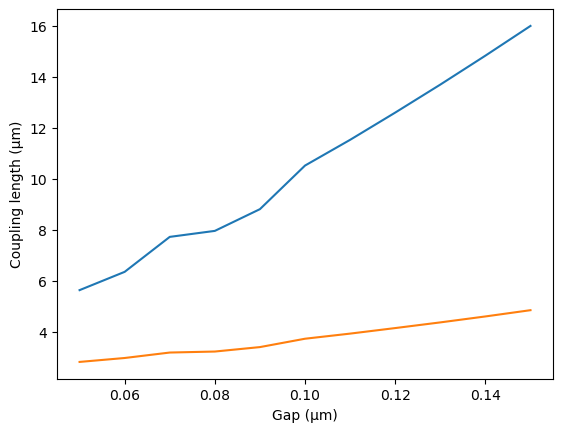

In [17]:
coupler = gt.modes.WaveguideCoupler(
    wavelength=1.55,
    core_width=(0.45, 0.45),
    core_thickness=220 * nm,
    core_material="si",
    clad_material="sio2",
    num_modes=4,
    gap=100 * nm,
)

print("\nCoupler:", coupler)
print("Effective indices:", coupler.n_eff)
print("Mode areas:", coupler.mode_area)
print("Coupling length:", coupler.coupling_length())

gaps = np.linspace(0.05, 0.15, 11)
lengths = gt.modes.sweep_coupling_length(coupler, gaps)
plt.plot(gaps, lengths)
plt.xlabel("Gap (μm)")
plt.ylabel("Coupling length (μm)")

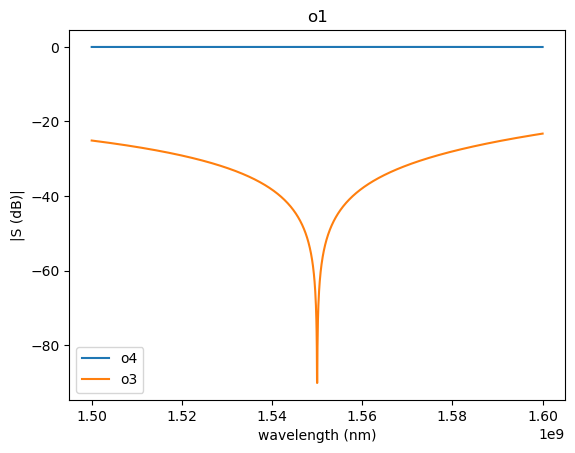

In [18]:
coupler_sc = partial(gs.models.coupler, dn=0.026, length=0, coupling0=0)
gs.plot_model(coupler_sc)

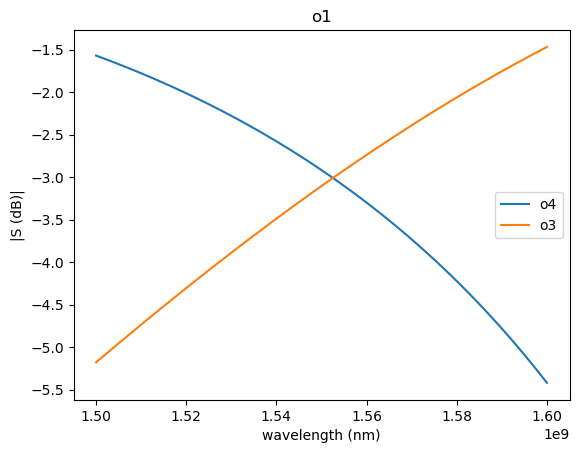

In [19]:
coupler_sc = partial(gs.models.coupler, dn=0.026, length=29.4 / 2, coupling0=0)
gs.plot_model(coupler_sc)

In [20]:
filepath = PATH.test_data / "sp" / "coupler_G224n_L20_S220.csv"

In [21]:
coupler_fdtd = gs.read.model_from_csv(
    filepath=filepath,
    xkey="wavelength_nm",
    prefix="S",
    xunits=1e-3,
)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\oaper\\anaconda3\\Lib\\site-packages\\test-data\\sp\\coupler_G224n_L20_S220.csv'

In [22]:
gs.plot_model(coupler_fdtd)

NameError: name 'coupler_fdtd' is not defined

In [23]:
f = jnp.linspace(constants.c / 1.0e-6, constants.c / 2.0e-6, 500) * 1e-12  # THz
wl = constants.c / (f * 1e12) * 1e6  # um

coupler_fdtd = gs.read.model_from_csv(
    filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)

k = sd["o1", "o3"]
t = sd["o1", "o4"]
s = t + k
a = t - k

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\oaper\\anaconda3\\Lib\\site-packages\\test-data\\sp\\coupler_G224n_L20_S220.csv'

In [24]:
plt.plot(wl, jnp.abs(s))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("symmetric (transmission + coupling)")
plt.legend()
plt.show()

NameError: name 's' is not defined

In [25]:
plt.plot(wl, jnp.abs(a))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("anti-symmetric (transmission - coupling)")
plt.legend()
plt.show()

NameError: name 'a' is not defined

In [26]:
@jax.jit
def coupler(wl=1.5):
    wl = jnp.asarray(wl)
    wl_shape = wl.shape
    wl = wl.ravel()
    t = (0.5 * (fs(wl) + fa(wl))).reshape(*wl_shape)
    k = (0.5 * (fs(wl) - fa(wl))).reshape(*wl_shape)
    sdict = {
        ("o1", "o4"): t,
        ("o1", "o3"): k,
        ("o2", "o3"): k,
        ("o2", "o4"): t,
    }
    return sax.reciprocal(sdict)

In [27]:
f = jnp.linspace(constants.c / 1.0e-6, constants.c / 2.0e-6, 500) * 1e-12  # THz
wl = constants.c / (f * 1e12) * 1e6  # um

coupler_fdtd = gs.read.model_from_csv(
    filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)
sd_ = coupler(wl=wl)

T = jnp.abs(sd["o1", "o4"]) ** 2
K = jnp.abs(sd["o1", "o3"]) ** 2
T_ = jnp.abs(sd_["o1", "o4"]) ** 2
K_ = jnp.abs(sd_["o1", "o3"]) ** 2
dP = jnp.unwrap(jnp.angle(sd["o1", "o3"]) - jnp.angle(sd["o1", "o4"]))
dP_ = jnp.unwrap(jnp.angle(sd_["o1", "o3"]) - jnp.angle(sd_["o1", "o4"]))

plt.figure(figsize=(12, 3))
plt.plot(wl, T, label="T (fdtd)", c="C0", ls=":", lw="6")
plt.plot(wl, T_, label="T (model)", c="C0")

plt.plot(wl, K, label="K (fdtd)", c="C1", ls=":", lw="6")
plt.plot(wl, K_, label="K (model)", c="C1")

plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.twinx()
plt.plot(wl, dP, label="ΔΦ (fdtd)", color="C2", ls=":", lw="6")
plt.plot(wl, dP_, label="ΔΦ (model)", color="C2")

plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.figlegend(bbox_to_anchor=(1.08, 0.9))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\oaper\\anaconda3\\Lib\\site-packages\\test-data\\sp\\coupler_G224n_L20_S220.csv'

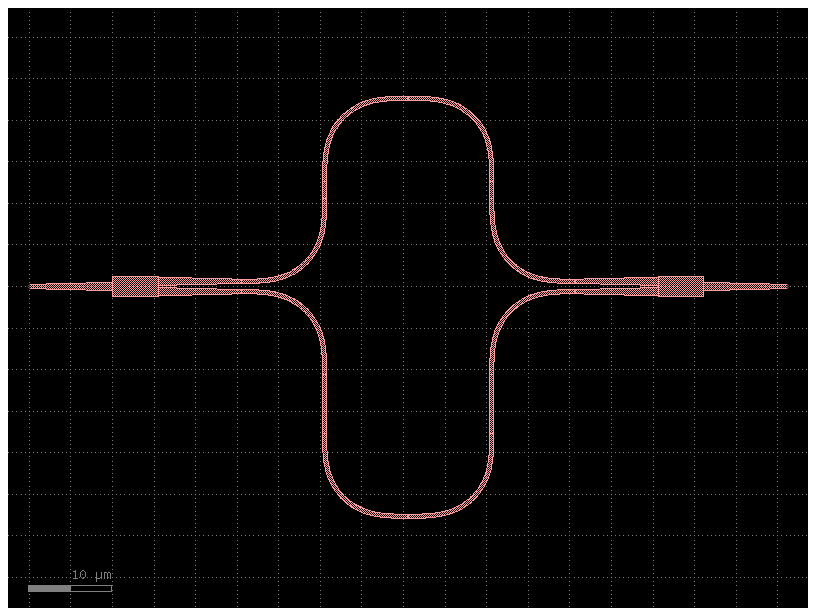

In [28]:
mzi = gf.components.mzi(delta_length=10)
mzi.plot()

<networkx.classes.graph.Graph object at 0x0000020C84990410>

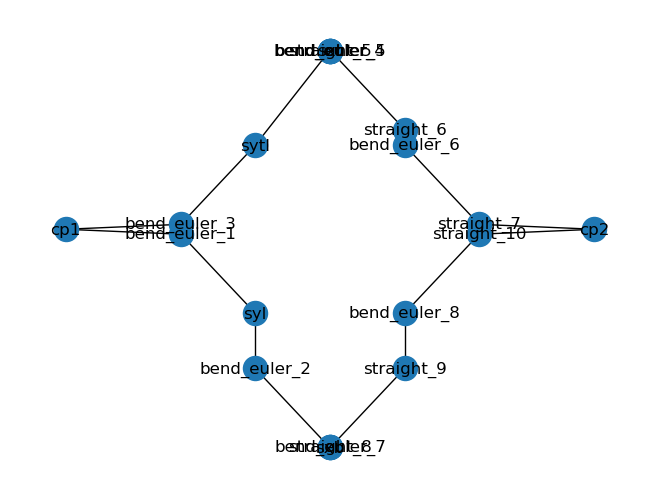

In [29]:
mzi.plot_netlist()

In [30]:
netlist = mzi.get_netlist()
pprint(netlist["connections"])

{'bend_euler_1,o1': 'cp1,o3',
 'bend_euler_1,o2': 'syl,o1',
 'bend_euler_2,o1': 'syl,o2',
 'bend_euler_2,o2': 'sxb,o1',
 'bend_euler_3,o1': 'cp1,o2',
 'bend_euler_3,o2': 'sytl,o1',
 'bend_euler_4,o1': 'sxt,o1',
 'bend_euler_4,o2': 'sytl,o2',
 'bend_euler_5,o1': 'straight_5,o2',
 'bend_euler_5,o2': 'straight_6,o1',
 'bend_euler_6,o1': 'straight_6,o2',
 'bend_euler_6,o2': 'straight_7,o1',
 'bend_euler_7,o1': 'straight_8,o2',
 'bend_euler_7,o2': 'straight_9,o1',
 'bend_euler_8,o1': 'straight_9,o2',
 'bend_euler_8,o2': 'straight_10,o1',
 'cp2,o2': 'straight_7,o2',
 'cp2,o3': 'straight_10,o2',
 'straight_5,o1': 'sxt,o2',
 'straight_8,o1': 'sxb,o2'}


In [31]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}

In [32]:
circuit, _ = sax.circuit(netlist=netlist, models=models)

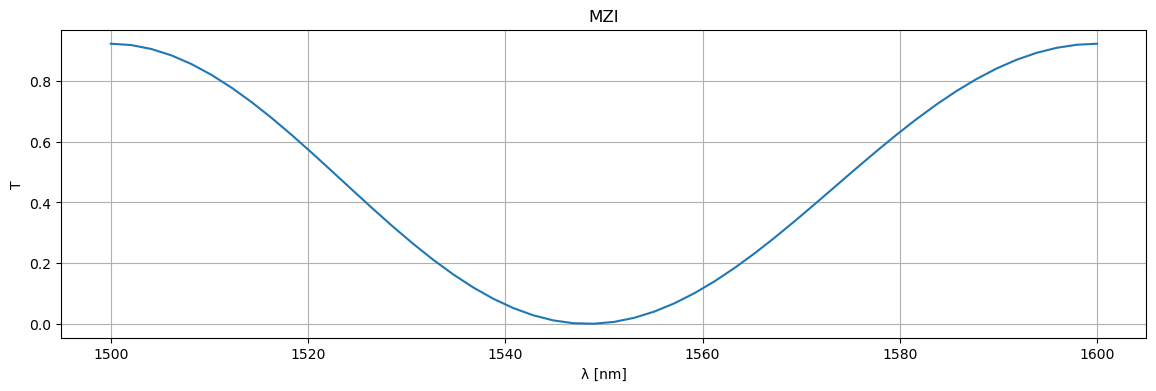

In [33]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

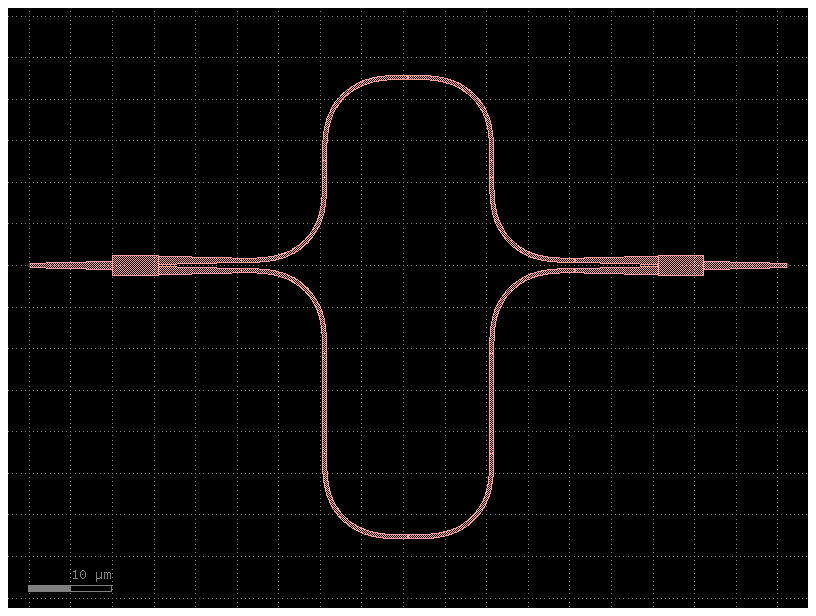

In [35]:
mzi = gf.components.mzi(delta_length=20)  # Double the length, reduces FSR by 1/2
mzi.plot()

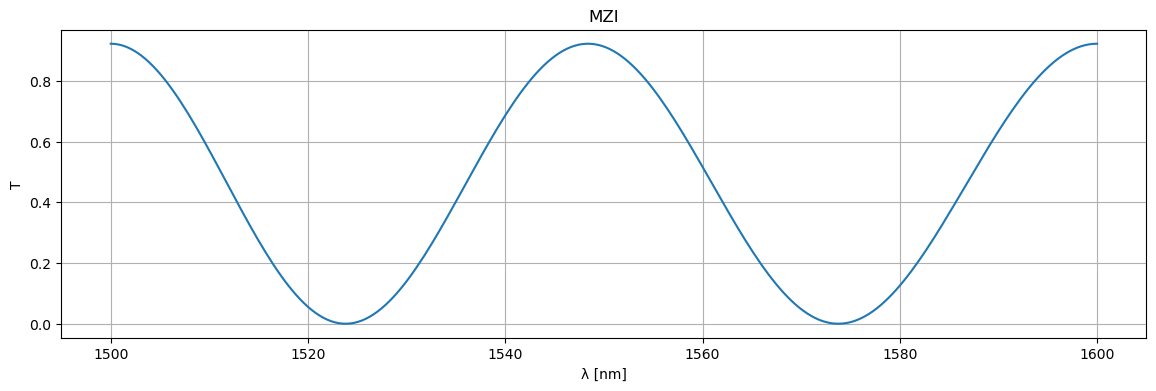

In [36]:
circuit, _ = sax.circuit(netlist=mzi.get_netlist(), models=models)

wl = np.linspace(1.5, 1.6, 256)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

In [37]:
nm = 1e-3
wavelengths = np.linspace(1.5, 1.6, 10)
widths = np.linspace(400 * nm, 600 * nm, 5)

neffs = gt.modes.sweep_n_eff(
    gt.modes.Waveguide(
        wavelength=wavelengths,
        core_width=widths[0],
        num_modes=1,
        core_thickness=220 * nm,
        slab_thickness=0.0,
        core_material="si",
        clad_material="sio2",
    ),
    core_width=widths,
)

neffs = neffs.values.real

  0%|          | 0/5 [00:00<?, ?it/s]

2024-04-18 20:44:29.602 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\oaper\.gdsfactory\modes\Waveguide_d32628b9695aa341.npz.
2024-04-18 20:44:39.066 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\oaper\.gdsfactory\modes\Waveguide_2571709ac1029f34.npz.
2024-04-18 20:44:49.243 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\oaper\.gdsfactory\modes\Waveguide_8c0f93db192bb844.npz.
2024-04-18 20:44:59.260 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\oaper\.gdsfactory\modes\Waveguide_fc508f323d95c51a.npz.
2024-04-18 20:45:08.882 | INFO     | gplugins.tidy3d.modes:_data:305 - store data into C:\Users\oaper\.gdsfactory\modes\Waveguide_9f5ead4d66e7a6ec.npz.


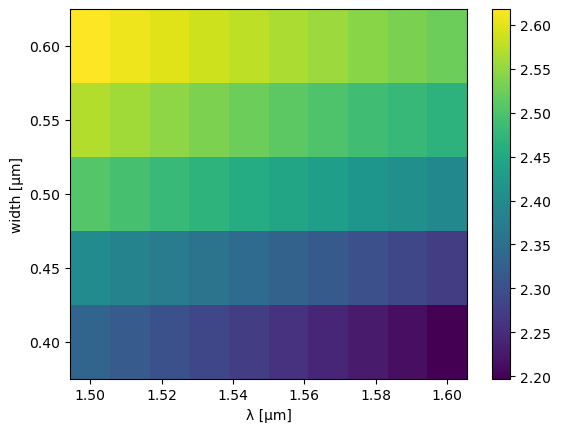

In [38]:
plt.pcolormesh(wavelengths, widths, neffs)
plt.xlabel("λ [μm]")
plt.ylabel("width [μm]")
plt.colorbar()
plt.show()

In [39]:
_grid = [jnp.sort(jnp.unique(widths)), jnp.sort(jnp.unique(wavelengths))]
_data = jnp.asarray(neffs)


@jax.jit
def _get_coordinate(arr1d: jnp.ndarray, value: jnp.ndarray):
    return jnp.interp(value, arr1d, jnp.arange(arr1d.shape[0]))


@jax.jit
def _get_coordinates(arrs1d: list[jnp.ndarray], values: jnp.ndarray):
    # don't use vmap as arrays in arrs1d could have different shapes...
    return jnp.array([_get_coordinate(a, v) for a, v in zip(arrs1d, values)])


@jax.jit
def neff(wl=1.55, width=0.5):
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(width), jnp.asarray(wl), 0))
    coords = _get_coordinates(_grid, params)
    return jax.scipy.ndimage.map_coordinates(_data, coords, 1, mode="nearest")


neff(wl=[1.52, 1.58], width=[0.5, 0.55])

Array([2.48335446, 2.48725569], dtype=float64)

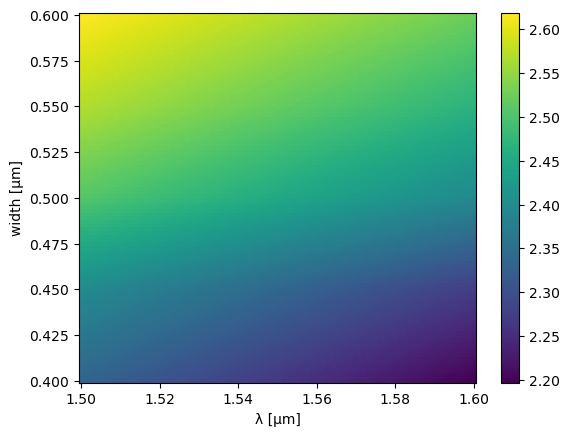

In [40]:
wavelengths_ = np.linspace(wavelengths.min(), wavelengths.max(), 100)
widths_ = np.linspace(widths.min(), widths.max(), 100)
wavelengths_, widths_ = np.meshgrid(wavelengths_, widths_)
neffs_ = neff(wavelengths_, widths_)
plt.pcolormesh(wavelengths_, widths_, neffs_)
plt.xlabel("λ [μm]")
plt.ylabel("width [μm]")
plt.colorbar()
plt.show()

In [41]:
def straight(wl=1.55, length=10.0, width=0.5):
    S = {
        ("o1", "o2"): jnp.exp(2j * np.pi * neff(wl=wl, width=width) / wl * length),
    }
    return sax.reciprocal(S)


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def mmi2x2():
    S = {
        ("o1", "o3"): 0.5**0.5,
        ("o1", "o4"): 1j * 0.5**0.5,
        ("o2", "o3"): 1j * 0.5**0.5,
        ("o2", "o4"): 0.5**0.5,
    }
    return sax.reciprocal(S)


def bend_euler(wl=1.5, length=20.0, width=0.5):
    """Let's assume a reduced transmission for the euler bend compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length, width=width).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "mmi2x2": mmi2x2,
    "straight": straight,
}

In [42]:
straight()

{
    ('o1', 'o2'): Array(0.34239487-0.93955615j, dtype=complex128),
    ('o2', 'o1'): Array(0.34239487-0.93955615j, dtype=complex128)
}

In [48]:
circuit, _ = sax.circuit(netlist=mzi.get_netlist(), models=models)
circuit()

{
    ('o1', 'o1'): Array(0.+0.j, dtype=complex128),
    ('o1', 'o2'): Array(0.31378674-0.0985655j, dtype=complex128),
    ('o2', 'o1'): Array(0.31378674-0.0985655j, dtype=complex128),
    ('o2', 'o2'): Array(0.+0.j, dtype=complex128)
}

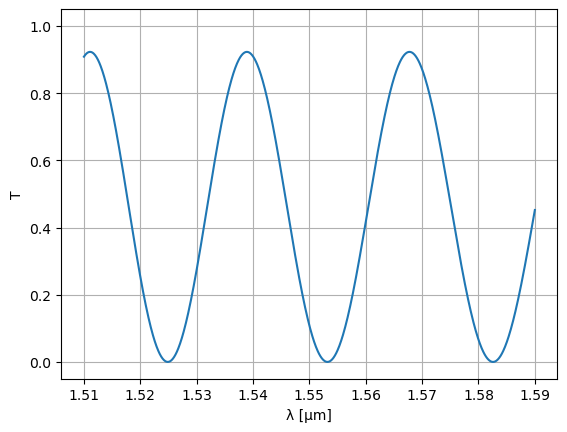

In [49]:
wl = jnp.linspace(1.51, 1.59, 1000)
S = circuit(wl=wl)
plt.plot(wl, abs(S["o1", "o2"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [μm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

In [51]:
def create_wafermaps(placements, correlation_length=1.0, num_maps=1, mean=0.0, std=1.0):
    dx = dy = correlation_length / 200
    xs, ys = (
        [p["x"] for p in placements.values()],
        [p["y"] for p in placements.values()],
    )
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    wx, wy = xmax - xmin, ymax - ymin
    xmin, xmax, ymin, ymax = xmin - wx, xmax + wx, ymin - wy, ymax + wy
    x, y = np.arange(xmin, xmax + dx, dx), np.arange(ymin, ymax + dy, dy)
    W0 = np.random.randn(num_maps, x.shape[0], y.shape[0])

    fx, fy = (
        fftshift(fftfreq(x.shape[0], d=x[1] - x[0])),
        fftshift(fftfreq(y.shape[0], d=y[1] - y[0])),
    )
    fY, fX = np.meshgrid(fy, fx)
    fW = fftshift(fft2(W0))

    if correlation_length >= min(x.shape[0], y.shape[0]):
        fW = np.zeros_like(fW)
    else:
        fW = np.where(np.sqrt(fX**2 + fY**2)[None] > 1 / correlation_length, 0, fW)

    W = np.abs(fftshift(ifft2(fW))) ** 2
    mean_ = W.mean(1, keepdims=True).mean(2, keepdims=True)
    std_ = W.std(1, keepdims=True).std(2, keepdims=True)
    if (std_ == 0).all():
        std_ = 1

    W = (W - mean_) / std_
    W = W * std + mean
    return x, y, W

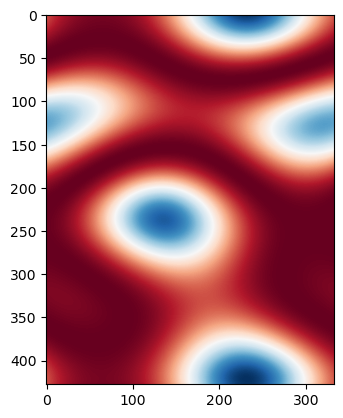

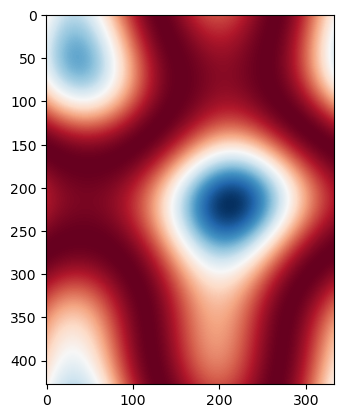

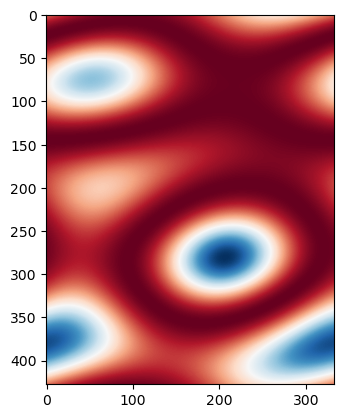

In [52]:
placements = mzi.get_netlist()["placements"]
xm, ym, wmaps = create_wafermaps(
    placements, correlation_length=100, mean=0.5, std=0.002, num_maps=100
)

for i, wmap in enumerate(wmaps):
    plt.imshow(wmap, cmap="RdBu")
    plt.show()
    if i == 2:
        break

In [53]:
def widths(xw, yw, wmaps, x, y):
    _wmap_grid = [xw, yw]
    params = jnp.stack(jnp.broadcast_arrays(jnp.asarray(x), jnp.asarray(y)), 0)
    coords = _get_coordinates(_wmap_grid, params)

    map_coordinates = partial(
        jax.scipy.ndimage.map_coordinates, coordinates=coords, order=1, mode="nearest"
    )
    return jax.vmap(map_coordinates)(wmaps)

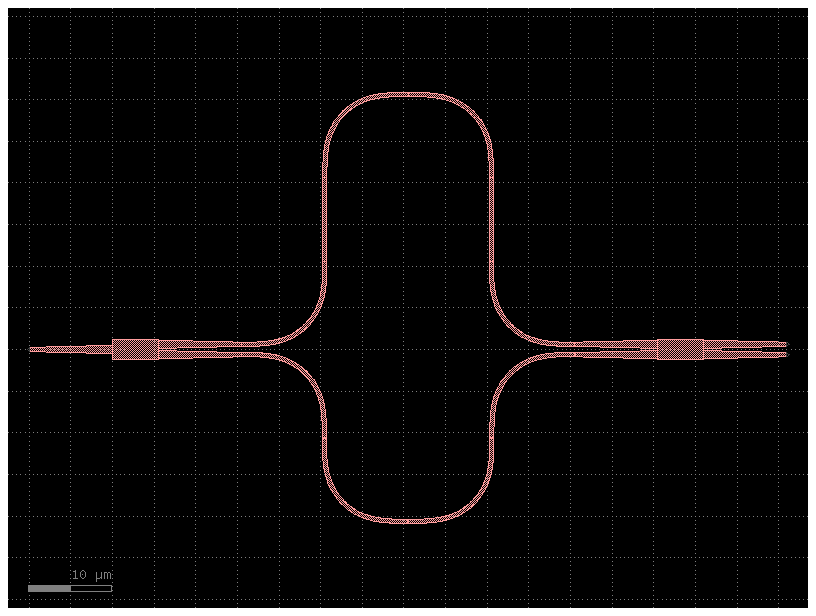

In [54]:
@gf.cell
def simple_mzi():
    global bend_top1_
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight(length=10.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in_ = c << mmi_in
    mmi_out_ = c << mmi_out
    straight_top1_ = c << half_delay_straight
    straight_top2_ = c << half_delay_straight
    bend_top1_ = c << bend
    bend_top2_ = (c << bend).mirror()
    bend_top3_ = (c << bend).mirror()
    bend_top4_ = c << bend
    bend_btm1_ = (c << bend).mirror()
    bend_btm2_ = c << bend
    bend_btm3_ = c << bend
    bend_btm4_ = (c << bend).mirror()

    # connections
    bend_top1_.connect("o1", mmi_in_.ports["o2"])
    straight_top1_.connect("o1", bend_top1_.ports["o2"])
    bend_top2_.connect("o1", straight_top1_.ports["o2"])
    bend_top3_.connect("o1", bend_top2_.ports["o2"])
    straight_top2_.connect("o1", bend_top3_.ports["o2"])
    bend_top4_.connect("o1", straight_top2_.ports["o2"])

    bend_btm1_.connect("o1", mmi_in_.ports["o3"])
    bend_btm2_.connect("o1", bend_btm1_.ports["o2"])
    bend_btm3_.connect("o1", bend_btm2_.ports["o2"])
    bend_btm4_.connect("o1", bend_btm3_.ports["o2"])

    mmi_out_.connect("o1", bend_btm4_.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in_.ports["o1"],
    )
    c.add_port("o2", port=mmi_out_.ports["o3"])
    c.add_port("o3", port=mmi_out_.ports["o4"])
    return c


mzi = simple_mzi()
mzi.plot()

In [56]:
circuit, _ = sax.circuit(netlist=mzi.get_netlist(), models=models)

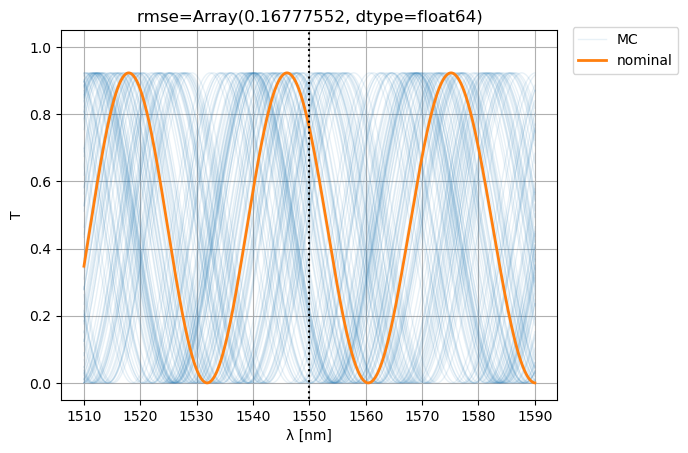

In [58]:
mzi_params = sax.get_settings(circuit)
placements = mzi.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = circuit(wl=wl)
S = circuit(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

In [59]:
@gf.cell
def compact_mzi():
    c = gf.Component()

    # instances
    mmi_in = gf.components.mmi1x2()
    mmi_out = gf.components.mmi2x2()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight()
    middle_straight = gf.components.straight(length=6.0)
    half_middle_straight = gf.components.straight(3.0)

    # references (sax convention: vars ending in underscore are references)
    mmi_in_ = c << mmi_in

    bend_top1_ = c << bend
    straight_top1_ = c << half_delay_straight
    bend_top2_ = (c << bend).mirror()
    straight_top2_ = c << middle_straight
    bend_top3_ = (c << bend).mirror()
    straight_top3_ = c << half_delay_straight
    bend_top4_ = c << bend

    straight_btm1_ = c << half_middle_straight
    bend_btm1_ = c << bend
    bend_btm2_ = (c << bend).mirror()
    bend_btm3_ = (c << bend).mirror()
    bend_btm4_ = c << bend
    straight_btm2_ = c << half_middle_straight

    mmi_out_ = c << mmi_out

    # connections
    bend_top1_.connect("o1", mmi_in_.ports["o2"])
    straight_top1_.connect("o1", bend_top1_.ports["o2"])
    bend_top2_.connect("o1", straight_top1_.ports["o2"])
    straight_top2_.connect("o1", bend_top2_.ports["o2"])
    bend_top3_.connect("o1", straight_top2_.ports["o2"])
    straight_top3_.connect("o1", bend_top3_.ports["o2"])
    bend_top4_.connect("o1", straight_top3_.ports["o2"])

    straight_btm1_.connect("o1", mmi_in_.ports["o3"])
    bend_btm1_.connect("o1", straight_btm1_.ports["o2"])
    bend_btm2_.connect("o1", bend_btm1_.ports["o2"])
    bend_btm3_.connect("o1", bend_btm2_.ports["o2"])
    bend_btm4_.connect("o1", bend_btm3_.ports["o2"])
    straight_btm2_.connect("o1", bend_btm4_.ports["o2"])

    mmi_out_.connect("o1", straight_btm2_.ports["o2"])

    # ports
    c.add_port(
        "o1",
        port=mmi_in_.ports["o1"],
    )
    c.add_port("o2", port=mmi_out_.ports["o3"])
    c.add_port("o3", port=mmi_out_.ports["o4"])
    return c

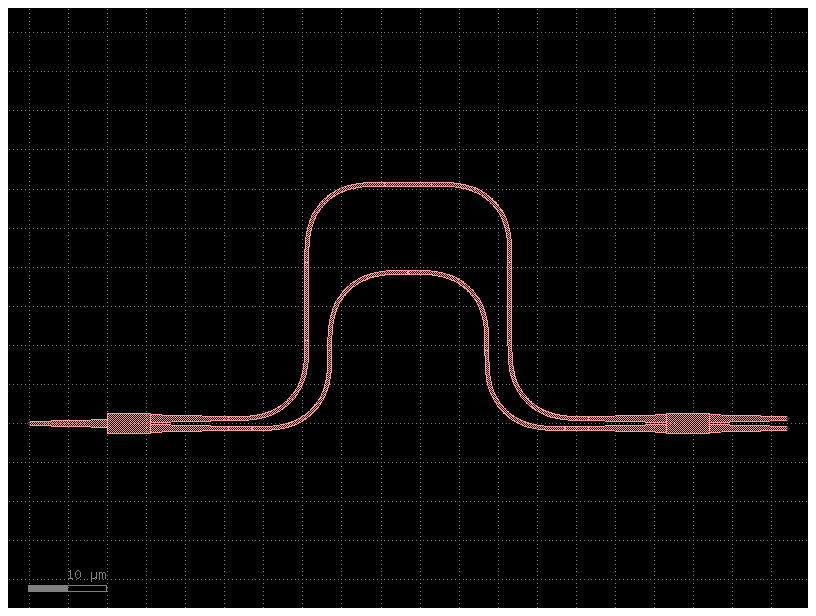

In [62]:
compact_mzi1 = compact_mzi()
fig = compact_mzi1.plot()
placements = compact_mzi1.get_netlist()["placements"]
mzi3, _ = sax.circuit(netlist=compact_mzi1.get_netlist(), models=models)

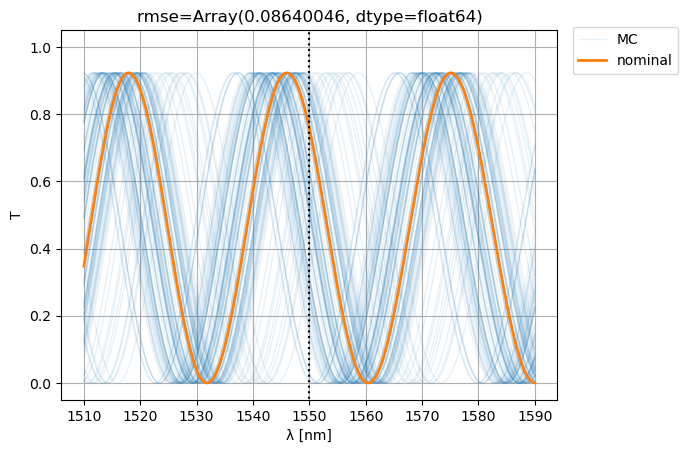

In [64]:
mzi_params = sax.get_settings(mzi3)
placements = compact_mzi1.get_netlist()["placements"]
width_params = {
    k: {"width": widths(xm, ym, wmaps, v["x"], v["y"])}
    for k, v in placements.items()
    if "width" in mzi_params[k]
}

S0 = mzi3(wl=wl)
S = mzi3(
    wl=wl[:, None],
    **width_params,
)
ps = plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, color="C0", lw=1, alpha=0.1)
nps = plt.plot(wl * 1e3, abs(S0["o1", "o2"]) ** 2, color="C1", lw=2, alpha=1)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1550, 1550], [-1, 2], color="black", ls=":")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.figlegend([*ps[-1:], *nps], ["MC", "nominal"], bbox_to_anchor=(1.1, 0.9))
rmse = jnp.mean(
    jnp.abs(jnp.abs(S["o1", "o2"]) ** 2 - jnp.abs(S0["o1", "o2"][:, None]) ** 2) ** 2
)
plt.title(f"{rmse=}")
plt.show()

2024-04-18 20:55:07.190 | WARNING  | gdsfactory.component_reference:connect:808 - Port layer mismatch: (47, 0) != (49, 0) in taper_724fbfc5
2024-04-18 20:55:07.191 | WARNING  | gdsfactory.component_reference:connect:815 - Port type mismatch: optical != electrical in taper_724fbfc5
2024-04-18 20:55:07.192 | WARNING  | gdsfactory.component_reference:connect:808 - Port layer mismatch: (47, 0) != (49, 0) in taper_724fbfc5
2024-04-18 20:55:07.193 | WARNING  | gdsfactory.component_reference:connect:815 - Port type mismatch: optical != electrical in taper_724fbfc5


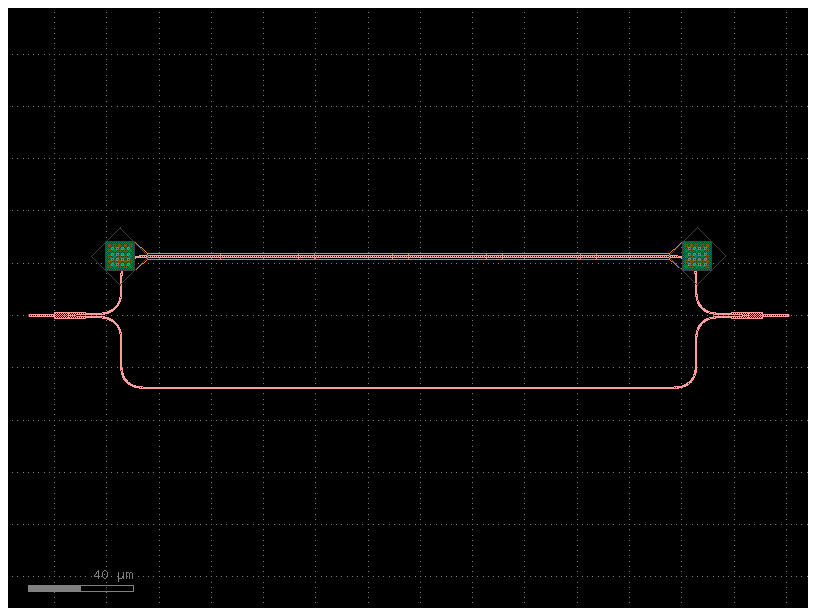

In [65]:
delta_length = 10
mzi_component = gf.components.mzi_phase_shifter(delta_length=delta_length)
mzi_component.plot()

In [66]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2() -> sax.SDict:
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0) -> sax.SDict:
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


def phase_shifter_heater(
    wl: float = 1.55,
    neff: float = 2.34,
    voltage: float = 0,
    length: float = 10,
    loss: float = 0.0,
) -> sax.SDict:
    """Returns simple phase shifter model"""
    deltaphi = voltage * jnp.pi
    phase = 2 * jnp.pi * neff * length / wl + deltaphi
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
            ("l_e1", "r_e1"): 0.0,
            ("l_e2", "r_e2"): 0.0,
            ("l_e3", "r_e3"): 0.0,
            ("l_e4", "r_e4"): 0.0,
        }
    )


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

In [68]:
mzi_component = gf.components.mzi_phase_shifter(delta_length=delta_length)
netlist = sax.netlist(mzi_component.get_netlist())

In [69]:
mzi_circuit, _ = sax.circuit(netlist=netlist, models=models, backend="filipsson_gunnar")
S = mzi_circuit(wl=1.55)
{k: v for k, v in S.items() if abs(v) > 1e-5}

{
    ('o2', 'o1'): Array(0.45079765+0.57272892j, dtype=complex128),
    ('o1', 'o2'): Array(0.45079765+0.57272892j, dtype=complex128)
}

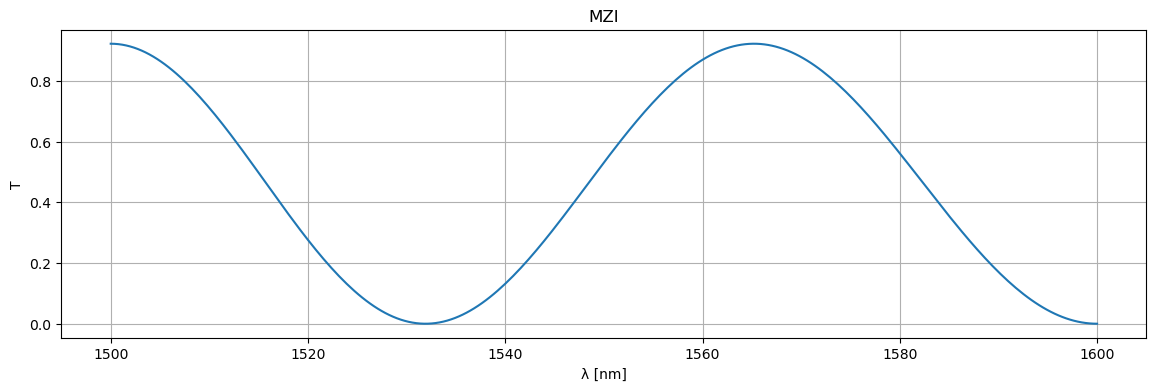

In [70]:
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

<networkx.classes.graph.Graph object at 0x0000020C90781F90>

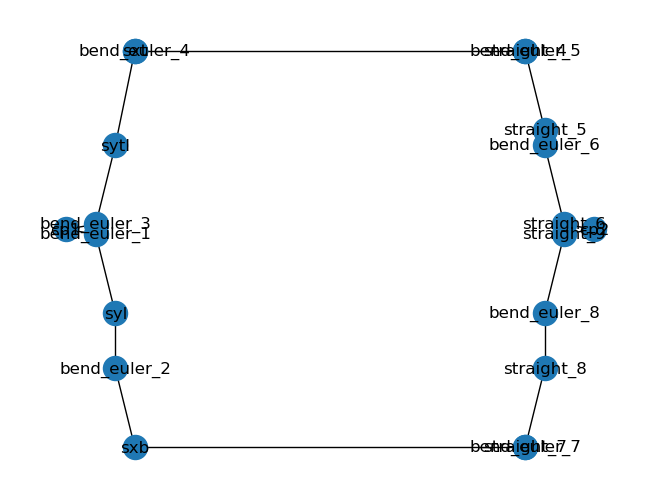

In [71]:
mzi_component.plot_netlist()

c:\Users\oaper\anaconda3\Lib\site-packages\gdsfactory\read\from_yaml.py:803: UserWarning: YAML defined: (bend_euler_4, bend_euler_1, bend_euler_6, bend_euler_3, bend_euler_2, cp2, bend_euler_5, bend_euler_7, straight_7, bend_euler_8, straight_4) with both connection and placement. Please use one or the other.
  warnings.warn(


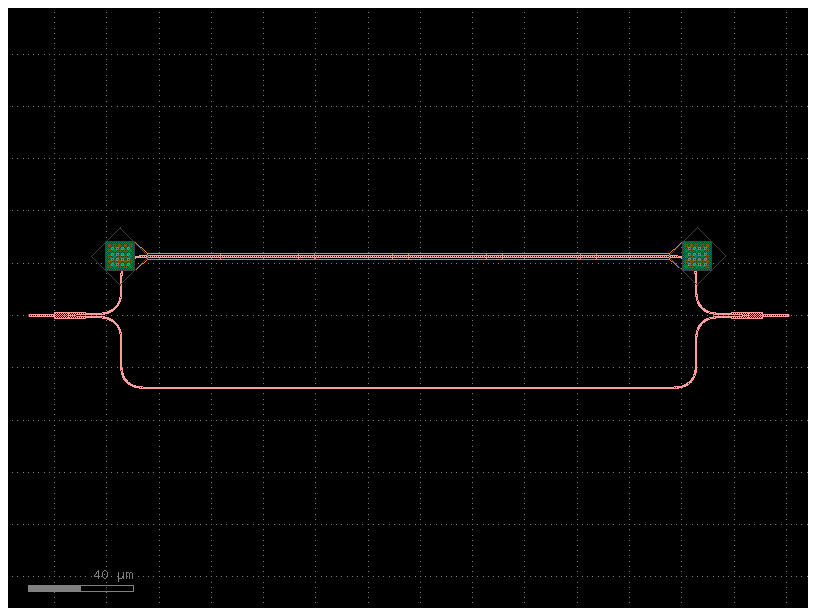

In [72]:
mzi_yaml = mzi_component.get_netlist()
mzi_component2 = gf.read.from_yaml(mzi_yaml)
mzi_component2.plot()

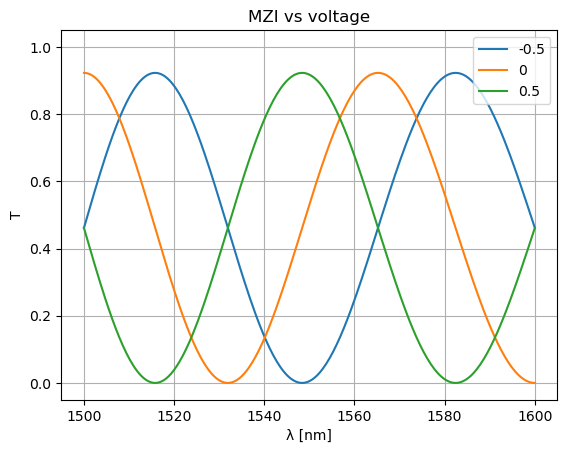

In [73]:
voltages = np.linspace(-1, 1, num=5)
voltages = [-0.5, 0, 0.5]

for voltage in voltages:
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, label=str(voltage))
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.title("MZI vs voltage")
plt.legend()

In [92]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}

In [93]:
delta_length = 30
mzi_component = gf.components.mzi(delta_length=delta_length)
mzi_circuit, _ = sax.circuit(netlist=mzi_component.get_netlist(), models=models)
S = mzi_circuit(wl=1.55)
print(S)

{('o1', 'o1'): Array(0.+0.j, dtype=complex128), ('o1', 'o2'): Array(-0.14382786+0.02173535j, dtype=complex128), ('o2', 'o1'): Array(-0.14382786+0.02173535j, dtype=complex128), ('o2', 'o2'): Array(0.+0.j, dtype=complex128)}


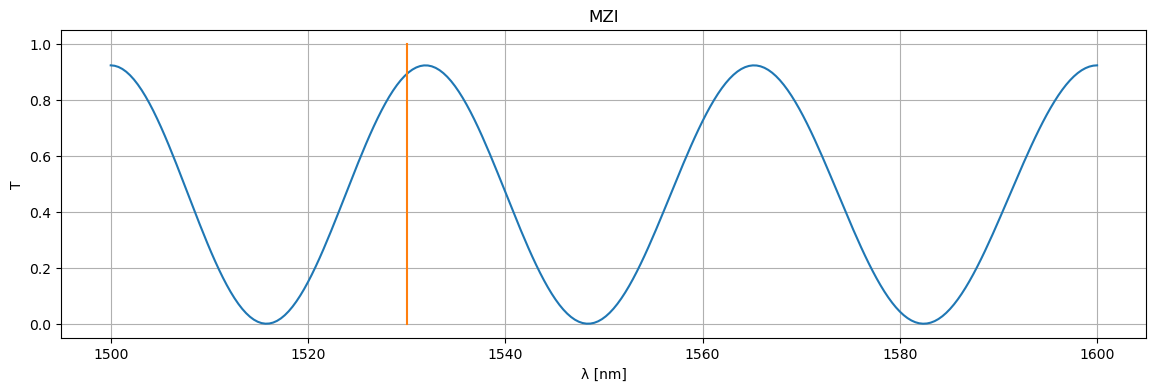

In [94]:
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.plot([1530, 1530], [0, 1])
plt.grid(True)
plt.show()

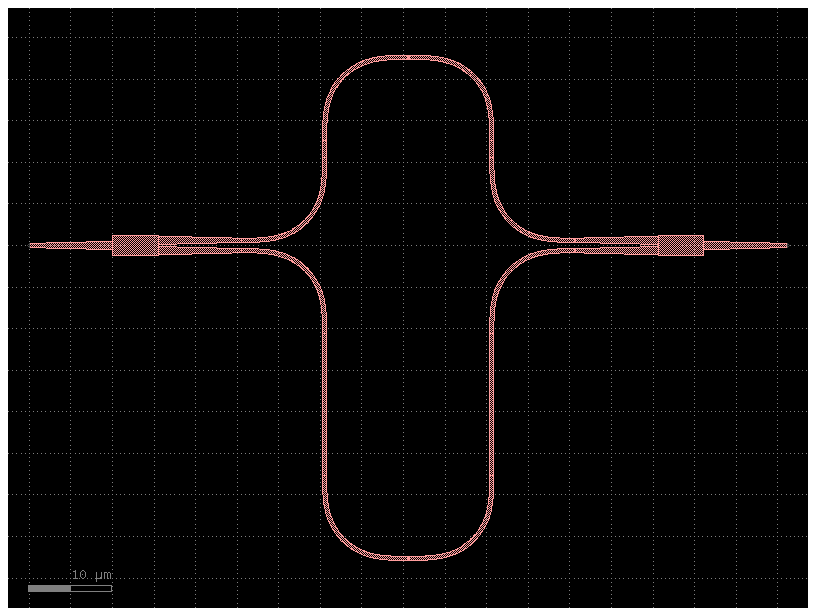

In [95]:
netlist = mzi_component.get_netlist()
c = gf.read.from_yaml(netlist)
c.plot()

In [96]:
mzi_component = gf.components.mzi(
    delta_length=delta_length,
)
mzi_circuit, _ = sax.circuit(
    netlist=mzi_component.get_netlist(),
    models=models,
)


@jax.jit
def loss_fn(delta_length):
    S = mzi_circuit(
        wl=1.53,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

In [103]:
%time loss_fn(20.0)

CPU times: total: 0 ns
Wall time: 0 ns


Array(0.14019539, dtype=float64)

In [106]:
obs_array = []
delta_length_array = np.linspace(19.5,20.5, 101)
for delta_length in delta_length_array:
    obs_array = obs_array + [loss_fn(delta_length)]


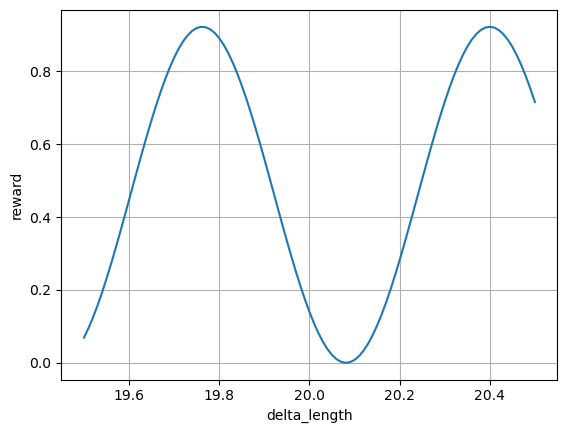

In [108]:

plt.figure()
plt.plot(delta_length_array, obs_array)
plt.xlabel("delta_length")
plt.ylabel("reward")
plt.grid()


In [80]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

In [81]:
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

In [82]:
def step_fn(step, state):
    settings = params_fn(state)
    loss = loss_fn(settings)
    grad = grad_fn(settings)
    state = update_fn(step, grad, state)
    return loss, state

In [83]:
range_ = trange(100)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=f"{loss:.6f}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [84]:
delta_length = params_fn(state)
print(delta_length)

29.642314405437023


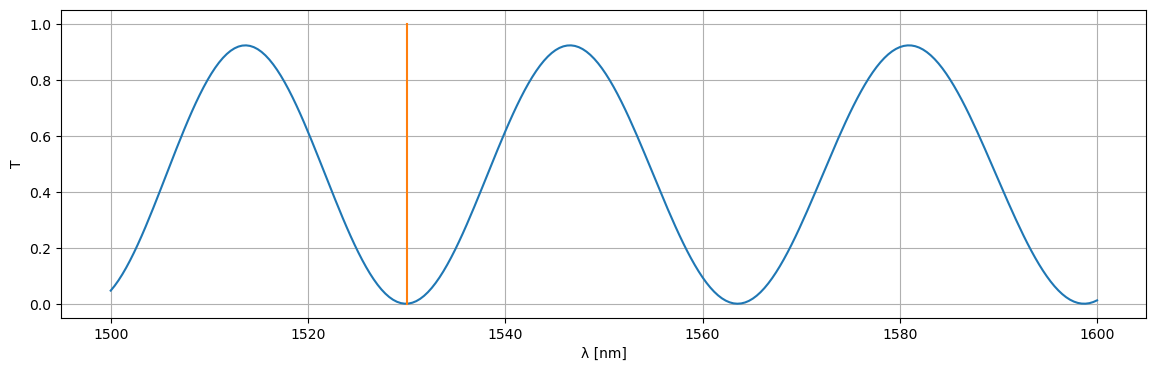

In [85]:
S = mzi_circuit(
    wl=wl,
    syl={"length": delta_length / 2 + 2},
    straight_9={"length": delta_length / 2 + 2},
)
plt.figure(figsize=(14, 4))
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1530, 1530], [0, 1])
plt.grid(True)
plt.show()

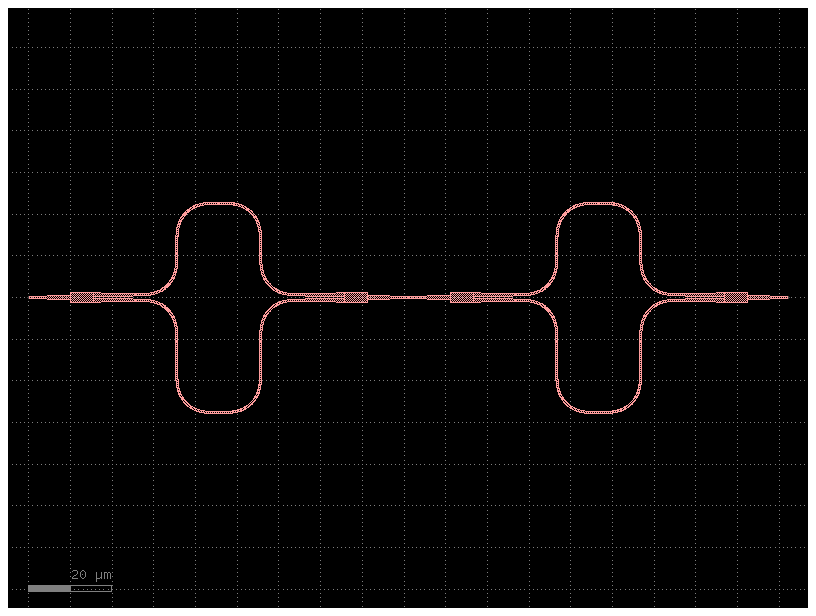

In [86]:
@gf.cell
def mzis(delta_length=10):
    c = gf.Component()
    c1 = c << gf.components.mzi(delta_length=delta_length)
    c2 = c << gf.components.mzi(delta_length=delta_length)
    c2.connect("o1", c1.ports["o2"])

    c.add_port("o1", port=c1.ports["o1"])
    c.add_port("o2", port=c2.ports["o2"])
    return c


def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    """Straight model."""
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """Assumes reduced transmission for the euler bend compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}


c2 = mzis()
c2.plot()

<networkx.classes.graph.Graph object at 0x0000020C8D580550>

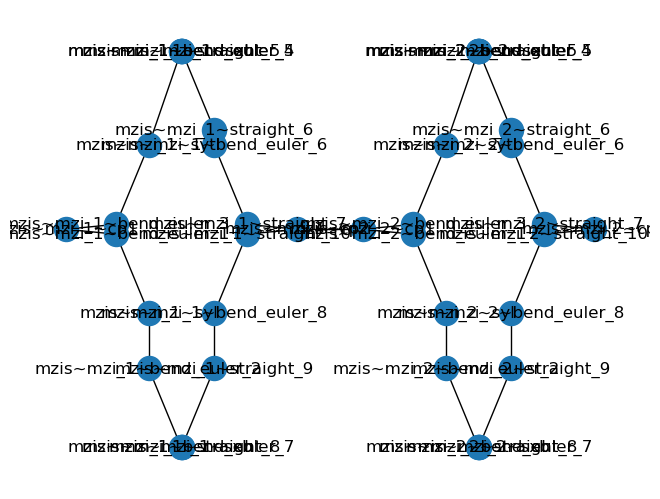

In [87]:
c2.plot_netlist_flat()

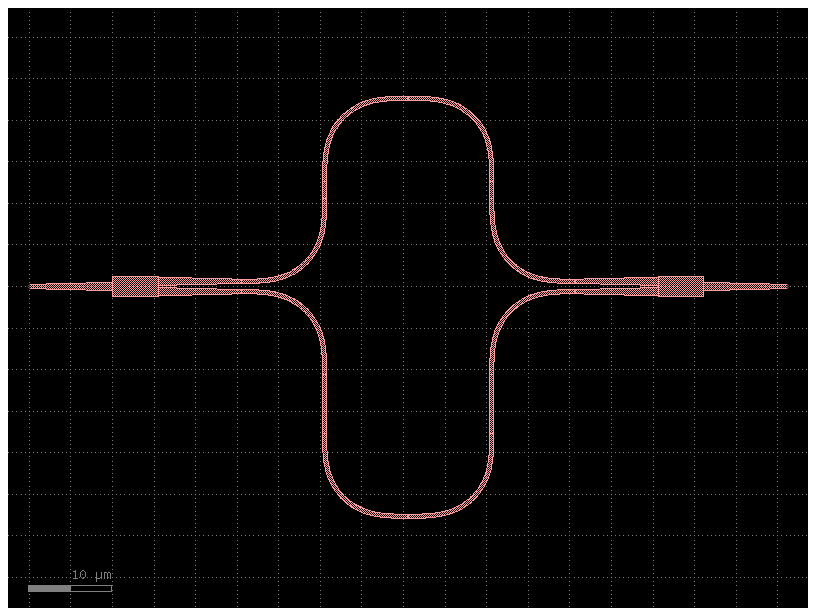

In [88]:
c1 = gf.components.mzi(delta_length=10)
c1.plot()

<networkx.classes.graph.Graph object at 0x0000020CA1414190>

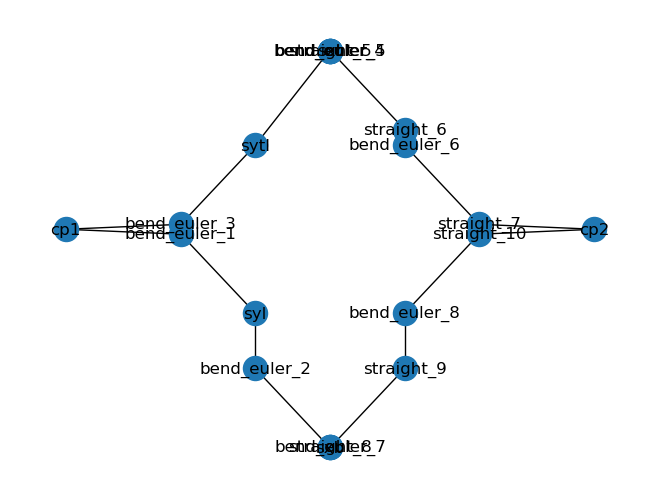

In [89]:
c1.plot_netlist()

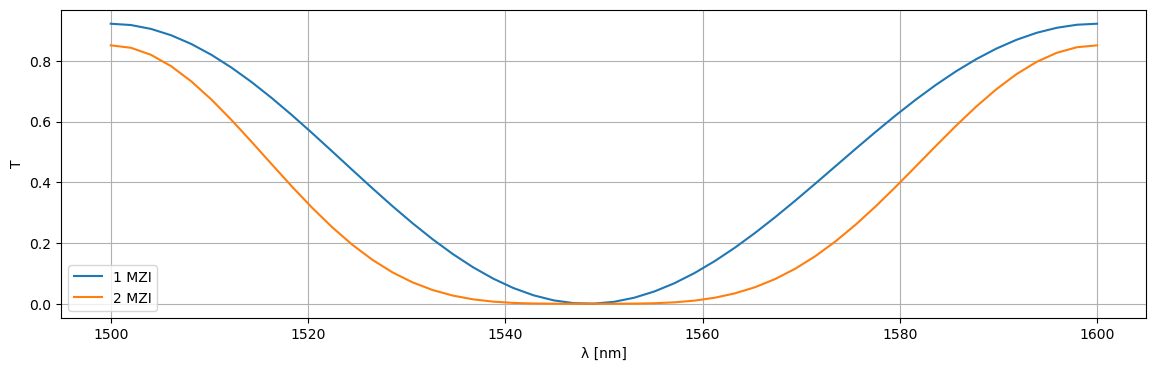

In [90]:
wl = np.linspace(1.5, 1.6)
netlist1 = c1.get_netlist_recursive()
circuit1, _ = sax.circuit(netlist=netlist1, models=models)
S1 = circuit1(wl=wl)

netlist2 = c2.get_netlist_recursive()
circuit2, _ = sax.circuit(netlist=netlist2, models=models)
S2 = circuit2(wl=wl)

plt.figure(figsize=(14, 4))
plt.plot(1e3 * wl, jnp.abs(S1["o1", "o2"]) ** 2, label="1 MZI")
plt.plot(1e3 * wl, jnp.abs(S2["o1", "o2"]) ** 2, label="2 MZI")
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.legend()
plt.show()